In [5]:
import numpy as np
import h5py
import bisect
from matplotlib import pyplot as plt

In [6]:
f = h5py.File('./digits.h5')
images = f["images"].value
labels = f["labels"].value
f.close()

images = images.reshape(len(images), 81)/255

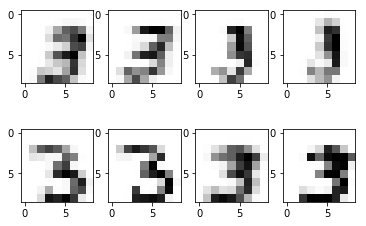

In [7]:
fig, ax = plt.subplots(2, 4)
for i in range(8):
    ax[i // 4, i % 4].imshow(images[labels == 3][i].reshape(9, 9), cmap='Greys')
plt.show()

# Question 1: Sampling from Naive Bayes

This is the working example provided by Prof. Köthe.

In [8]:
class Histogram(object):
    """Histogram.
    """

    def __init__(self, values):
        """Create a histogram for the given values using the Freedman-Diaconis rule for the bin width.

        :param values: the values from which the histogram will be computed
        """
        self.num_instances = len(values)

        # Get the number of bins.
        v_min, v_25, v_75, v_max = np.percentile(values, [0, 25, 75, 100])
        # freedman_diaconis_width = 2 * (v_75 - v_25) / (len(values) ** (1/3.0))
        freedman_diaconis_width = (v_max - v_min) / (len(values) ** (1/3.0))
        num_bins = int(round((v_max - v_min) / freedman_diaconis_width))
        assert num_bins > 0

        # Fill the bins.
        self.heights, self.bin_edges = np.histogram(values, bins=num_bins)

    def find_bin(self, value):
        """Find the bin index of the given value.

        :param value: some value
        :return: bin index
        """
        bin_index = bisect.bisect_left(self.bin_edges, value) - 1
        bin_index = max(bin_index, 0)
        bin_index = min(bin_index, len(self.heights)-1)
        return bin_index

    def bin_probability(self, bin_index):
        """Return the bin probability of the desired bin.

        :param bin_index: index of the bin
        :return: probability of the bin
        """
        assert 0 <= bin_index <= len(self.heights) - 1
        return self.heights[bin_index] / float(self.num_instances)
class NaiveBayesClassifier(object):
    """Naive Bayes classifier.
    """

    def __init__(self):
        self.num_instances = None  # Number of instances that were used in training.
        self.num_feats = None  # Number of features that were used in training.
        self.classes = None  # The classes that were found in training.
        self.histograms = {}  # Dict with histograms, key: class, value: list with histograms for all features.
        self.priors = {}  # Dict with priors, key: class, value: prior of the class.

    def train(self, train_x, train_y):
        """Train the classifier.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert train_x.shape[0] == len(train_y)
        self.num_instances = train_x.shape[0]
        self.num_feats = train_x.shape[1]
        self.classes = np.unique(train_y)

        # Create one histogram for each class and each feature.
        self.histograms.clear()
        self.priors.clear()
        for cl in self.classes:
            # Get the data of the current class.
            train_x_cl = [train_x[k] for k in range(self.num_instances) if train_y[k] == cl]
            num_instances_cl = len(train_x_cl)
            self.priors[cl] = num_instances_cl / float(self.num_instances)

            # Create one histogram per feature.
            self.histograms[cl] = []
            for i in range(self.num_feats):
                histo_points = [train_x_cl[k][i] for k in range(num_instances_cl)]
                self.histograms[cl].append(Histogram(histo_points))

    def probabilities_single(self, test_x):
        """Compute the class probabilities of a single instance.

        :param test_x: test x data of a single instance
        :return: probabilities of test_x for each class
        """
        assert len(test_x) == self.num_feats,\
            "NaiveBayesClassifier.probabilities_single(): Number of features in test and training must be the same."

        probs = {}
        for cl in self.classes:
            # Compute the likelihood.
            prob = self.priors[cl]
            for i in range(self.num_feats):
                # Find height of histogram bin with class cl that contains test_x[i].
                histo = self.histograms[cl][i]
                bin_index = histo.find_bin(test_x[i])
                prob *= histo.bin_probability(bin_index)
            probs[cl] = prob
        return probs

    def predict_single(self, test_x):
        """Predict the class of a single instance.

        :param test_x: test x data of a single instance
        :return: predicted class of test_x
        """
        probs = self.probabilities_single(test_x)
        max_cl = max(probs.keys(), key=lambda cl: probs[cl])
        return max_cl

    def predict(self, test_x):
        """Predict the classes of the given sample.

        :param test_x: test x data
        :return: predicted classes of test_x
        """
        assert test_x.shape[1] == self.num_feats,\
            "NaiveBayesClassifier.predict(): Number of features in test and training must be the same."
        return np.array([self.predict_single(test_x[i]) for i in range(test_x.shape[0])])

In [9]:
nb = NaiveBayesClassifier()
nb.train(images[labels == 3], labels[labels == 3])

## Sampling from histograms

In [10]:
def first_above_zero(z):
    z[z < 0] = 2 # disable all values where q is smaller than t, but do not delete them
    return np.argmin(z) # get the index
    
    
def sample_naive_bayes(histograms):
    q = [np.cumsum(histogram.heights)/np.sum(histogram.heights) for histogram in histograms] 

    # Print histogram and cumulative
    #fig, ax = plt.subplots(2, 1)
    #i = 27
    #width = histograms[i].bin_edges[1] - histograms[i].bin_edges[0]
    #ax[0].bar(histograms[i].bin_edges[:-1] + 0.5*width, histograms[i].heights, width)
    #ax[1].bar(histograms[i].bin_edges[:-1] + 0.5*width, q[i], width)
    #plt.show()
    
    t = np.random.rand(len(histograms))
    l = [first_above_zero(cum - t[i]) for i, cum in enumerate(q)]
    x = np.random.rand(len(histograms))
    
    return np.array([histogram.bin_edges[l[i]] + x[i]*(histogram.bin_edges[1] - histogram.bin_edges[1]) for i, histogram in enumerate(histograms)])

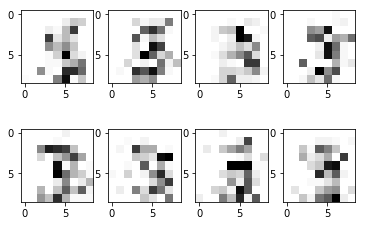

In [11]:
fig, ax = plt.subplots(2, 4)
for i in range(8):
    ax[i // 4, i % 4].imshow(sample_naive_bayes(nb.histograms[3]).reshape(9, 9), cmap='Greys')
plt.show()

# Question 2: Density trees

n is the number of cuts we make, i is the number of the perfect split.
Maximizing score $s$
\begin{align}
s &= -p_l^2 * V_l + p_\lambda^2*V_\lambda + p_\rho^2*V_\rho\\
&= -\frac{P_l^2}{V_l} + \frac{P_\lambda^2}{V_\lambda} + \frac{P_\rho^2}{V_\rho}\\
&= -\frac{P_l^2}{V_l} + \frac{P_\lambda^2}{i*V_l/n} + \frac{P_\rho^2}{(n-i)*V_l/n}\\
&= -\frac{P_l^2}{V_l} + \frac{n}{V_l}*\left(\frac{P_\lambda^2}{i} + \frac{P_\rho^2}{n-i}\right)
\end{align}
Here we used, that 
\begin{align}
V_\rho = d_{\rho,1}*...*d_{\rho,D} = \frac{i}{n}*d_{\lambda,1}*...*d_{\lambda,D} = \frac{i}{n}*V_\lambda
\end{align}

In [87]:
def volume(a):
    """
    Calculates the n-dimensional volume.
    """
    return np.prod(a[:,1])

class Node:
    def __init__(self, data, bbox, vol, tot_n):
        self.left = None
        self.right = None
        
        self.data = data # the actual data
        self.bbox = bbox # boundary box of the data, 2 dimensions, first is the start, second is the width
        
        self.vol = vol # the calculated volume
        self.prob = len(data)/tot_n  # probability of the node
        self.tot_n = tot_n # yeah it is crep to put it in every node, but it is late...
        
        self.best_split = None
    
    @staticmethod
    def score_min_error(n_l, n_r, tot_n, vol, i, n):
        # NOTE: maximizing this could be done with much less calculations
        return -((((n_l+n_r)/tot_n)**2)/vol) + n*((((n_l/tot_n)**2)/i) + (((n_r/tot_n)**2)/(n-i)))/vol
    
    @staticmethod
    def score_max_uniform(n_l, n_r, tot_n, vol, i, n):
        vol_left = vol*i/n  
        return ((n_l*vol - (n_r + n_l)*vol_left)**2)/(vol_left*(vol - vol_left))
    
    def get_score(self, score_func, n = 10):
        
        # if has been already calculated
        if self.best_split != None:
            return self.best_split["score"]
        
        # init
        self.best_split = {
            "score": 0,
            "left": None,
            "right": None,
            "dimension": None,
            "ratio": None
        }

        
        for d in range(self.data[0].shape[0]): # loop over all dimensions
            for i in range(1, n): # loop over the number of cuts
                
                # split the data into left and right box
                data_left = self.data[self.data[:,d] < self.bbox[d,0] + i*self.bbox[d,1]/n]
                data_right = self.data[self.data[:,d] >= self.bbox[d,0] + i*self.bbox[d,1]/n]
                
                # do not allow split which would just shrink the node
                # TODO: right?
                if len(data_left) == 0 or len(data_right) == 0:
                    continue
                
                # assert len(data_left) + len(data_right) == len(self.data)
                
                # call the given scoring function
                score = score_func(len(data_left), len(data_right), self.tot_n, self.vol, i, n)
                
                # if found a new highest score keep the current values
                if score > self.best_split["score"]:
                    self.best_split["score"] = score
                    self.best_split["left"] = data_left
                    self.best_split["right"] = data_right
                    self.best_split["dimension"] = d
                    self.best_split["ratio"] = i/n

        return self.best_split["score"]
    
    def split(self):
        
        # assert len(self.data) != 0
        
        bbox_left = np.copy(self.bbox)
        bbox_left[self.best_split["dimension"], 1] *= self.best_split["ratio"] # shrink the width for the left box
        self.left = Node(self.best_split["left"], bbox_left, self.vol*self.best_split["ratio"], self.tot_n)
        
        bbox_right = np.copy(self.bbox)
        bbox_right[self.best_split["dimension"], 0] += bbox_right[self.best_split["dimension"], 1]*self.best_split["ratio"] # move beginning of right box
        bbox_right[self.best_split["dimension"], 1] *= (1 - self.best_split["ratio"]) # shrink width of right box
        self.right = Node(self.best_split["right"], bbox_right, self.vol*(1 - self.best_split["ratio"]), self.tot_n)
        
        #### Tests on bounding boxes
        # Feel free to test but should pass :D
        # assert (volume(bbox_left) - self.left.vol) < 1e-6
        # assert (volume(bbox_right) - self.right.vol) < 1e-6
        # for i in range(81):
        #    if i == self.best_split["dimension"]:
        #        continue
        #    assert self.left.bbox[i, 0] == self.right.bbox[i, 0]
        #    assert self.left.bbox[i, 1] == self.right.bbox[i, 1]
        # assert self.right.bbox[self.best_split["dimension"], 0] == self.left.bbox[self.best_split["dimension"], 0] + self.left.bbox[self.best_split["dimension"], 1]

    @staticmethod
    def get_leaf_of_instance(node, instance):
        current = node
        while current.left != None: # avoid recursion
            if instance[current.best_split["dimension"]] > current.right.bbox[current.best_split["dimension"], 0]:
                current = current.right
            else:
                current = current.left
        return current

## Training

In [90]:
# DEBUG
def get_probability(node):
    """
    Recursively check the probability of the node and compare to precomputed one.
    """
    if node.left == None:
        return node.prob
    else:
        a = get_probability(node.left)
        b = get_probability(node.right)
        if np.abs(a + b - node.prob) > 1e-6:
            print(a, b, node.prob)
            raise ValueError('FATAL ERROR: probabilities do not match')
        return a + b

# DEBUG
def check_instances(node):
    """
    Check if each datapoint is inside the given boundary box
    """
    for i in node.data:
        for j in range(node.data[0].shape[0]):
            # should both be 0 for both
            if node.bbox[j, 0] - i[j] > 1e-6 or i[j] - node.bbox[j, 0] - node.bbox[j, 1] > 1e-6:
                print(i[j], node.bbox[j])
                raise ValueError('FATAL ERROR: instances outside of bounding box')


def fit_density_tree1(features, tau, score_func):
    
    bincount = int(tau*len(features)**(1/3))
    print('Use {:d} bins'.format(bincount))
    
    root_bounding = np.empty((features[0].shape[0], 2)) # init boundary box
    
    for i in range(features[0].shape[0]): # for each feature...
        root_bounding[i, 0] = np.min(features[:,i]) # ... start box at smallest value ... 
        root_bounding[i, 1] = np.max(features[:,i]) - np.min(features[:,i]) # ... and set a width of max-min
    
    # init root node
    root = Node(features, root_bounding, volume(root_bounding), len(features))
    
    # init leafs array
    leafs = [root]
    
    while len(leafs) < bincount:
        if int(bincount/100) == 0 or len(leafs) % int(bincount/100):
            print('Leafs: {:d}, {:.0f}%'.format(len(leafs), 100*len(leafs)/bincount), end='\r')
        
        # get the scores for each leaf
        scores = np.array([node.get_score(score_func) for node in leafs])

        # get the leaf with the highest score
        leaf_index = np.argmax(scores)
        
        # if the highest score is below 0: abbort
        if scores[leaf_index] <= 0:
            print('Highest score below 0, do not split any further.')
            break
        
        # split the leaf with highest score
        leafs[leaf_index].split()
        
        # append its children to the leaf
        leafs.append(leafs[leaf_index].left)
        leafs.append(leafs[leaf_index].right)

        # remove from leafs
        del leafs[leaf_index]
    
    print('Finished.', ' '*30)
    #print('Check for errors...')
    # DEBUG
    #for i in leafs:
    #    check_instances(i)
    #print('All instances are inside their boundaries in the leaf nodes')
    
    # DEBUG
    #print('Root node has probability of {:f}'.format(get_probability(root)))
    return root

In [91]:
tree_min_error = fit_density_tree1(images[labels == 3], 10, Node.score_min_error)

Use 230 bins
Finished.                               


In [92]:
tree_max_unif = fit_density_tree1(images[labels == 3], 10, Node.score_max_uniform)

Use 230 bins


/Users/maxsimon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


/Users/maxsimon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


Finished.9, 100%                               


## Sampling

In [105]:
def sample_density_tree(tree):
    t = np.random.rand()
    current = tree
    while current.left != None:
        if t <= current.prob:
            current = current.left     
        else:
            t -= current.prob
            current = current.right
    # current is now a leaf
    x = np.random.rand(current.data[0].shape[0]) # random numbers for inside the bins
    return current.bbox[:,0] + x*current.bbox[:,1]

### Minimizing error

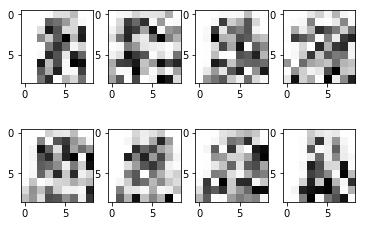

In [106]:
fig, ax = plt.subplots(2, 4)
for i in range(8):
    ax[i // 4, i % 4].imshow(sample_density_tree(tree_min_error).reshape(9, 9), cmap='Greys')
plt.show()

### Maximizing uniformity

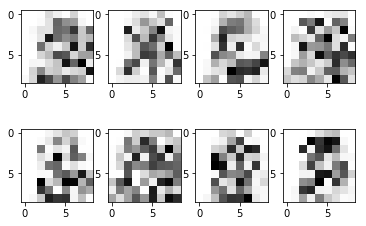

In [107]:
fig, ax = plt.subplots(2, 4)
for i in range(8):
    ax[i // 4, i % 4].imshow(sample_density_tree(tree_max_unif).reshape(9, 9), cmap='Greys')
plt.show()

## Classification

In [97]:
def predict_density_trees(test_features, tree_for_3, tree_for_9):
    predicted_labels = np.empty(len(test_features))
    for i, feature in enumerate(test_features):
        if Node.get_leaf_of_instance(tree_for_3, feature).prob < Node.get_leaf_of_instance(tree_for_9, feature).prob:
            predicted_labels[i] = 9
        else:
            predicted_labels[i] = 3
    return predicted_labels

In [98]:
#tree_3 = fit_density_tree1(images[labels == 3], 10, Node.score_min_error) already calculated
tree_9 = fit_density_tree1(images[labels == 9], 10, Node.score_min_error)

Use 228 bins
Finished.                               


In [99]:
def get_confusion_matrix(predicted, truth, possible_labels=[3, 9]):
    conf = np.empty((len(possible_labels), len(possible_labels)))
    for i, k in enumerate(possible_labels):
        items, counts = np.unique(predicted[truth == k], return_counts=True)
        count_array = np.array([counts[np.where(items == tested_k)[0][0]] for tested_k in possible_labels])
        conf[i] = count_array
    return conf

In [100]:
f = h5py.File('./digits_test.h5')
images_test = f["images"].value
labels_test = f["labels"].value
f.close()
images_test = images_test.reshape(len(images_test), 81)/255

In [101]:
mask = np.logical_or(labels_test == 3, labels_test == 9)
prediction = predict_density_trees(images_test[mask], tree_min_error, tree_9)
error_rate = np.count_nonzero(prediction - labels_test[mask])/prediction.shape[0]
conf_ma = get_confusion_matrix(prediction, labels_test[mask])

Error rate: 0.39222


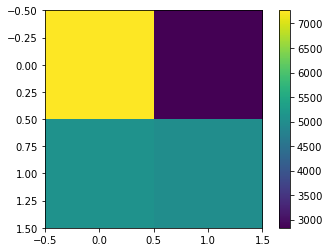

In [108]:
print('Error rate: {:.5f}'.format(error_rate))
fig, ax = plt.subplots(1, 1)
cax = ax.imshow(conf_ma)
plt.colorbar(cax)
plt.show()

Yep, the 3s look not like a typical 3 and the error rate is enormous.
The problem is, that we get very large bins

# Question 3: Sampling with QDA

In [109]:
def get_class(x, y, desired):
    """
    Returns a subarray of x where y = desired
    """
    return x[y == desired]
def fit_qda(training_features, training_labels, possible_features=[3]):
    D = training_features.shape[1] # dimension of features
    F = 1
    
    # create an array of testsetdata
    ts = [get_class(training_features, training_labels, feature) for feature in possible_features]
    # caculate the total amount of testdata (including all possible features)
    N_tot = sum([tsf.shape[0] for tsf in ts])

    # mu has the shape FxD
    mu = np.empty((F, D), dtype=float)
    # cov should have the shape FxDxD
    cov = np.empty((F, D, D))
    # the priors are scalars and have therefore the shape F
    p = np.empty(F)
    
    for i in range(F):
        N = ts[i].shape[0] # number of training instances for the feature possible_feature[i]
        # calculating mu
        mu[i] = np.mean(ts[i], axis=0)
    
        # calculating the covariance matrix
        ts_centralised = ts[i] - mu[i]
        # some numpy magic
        cov[i] = np.add.reduce(ts_centralised[:,:,np.newaxis] * ts_centralised[:,np.newaxis,:])/N
    
        # calculating the priors
        p[i] = N/N_tot
        
    # done
    return mu, cov, p


In [110]:
mu, cov, p = fit_qda(images[labels == 3], labels[labels == 3])

In [111]:
def sample_qda(mu, cov):
    return np.random.multivariate_normal(mu, cov)

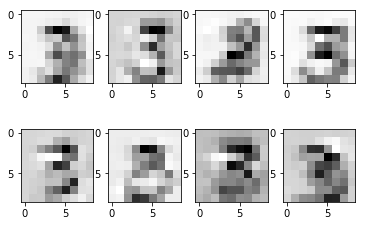

In [112]:
fig, ax = plt.subplots(2, 4)
for i in range(8):
    ax[i // 4, i % 4].imshow(sample_qda(mu[0], cov[0]).reshape(9, 9), cmap='Greys')
plt.show()